# Chapter 6: Fine-Tuning for Classification

In [2]:
from importlib.metadata import version

pkgs = ["matplotlib",
        "numpy",
        "tiktoken",
        "torch",
        "tensorflow",
        "pandas"
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.8
numpy version: 2.4.0
tiktoken version: 0.12.0
torch version: 2.9.1
tensorflow version: 2.20.0
pandas version: 2.3.3


## 6.2 Preparing the Dataset

We will apply classification fine-tuning to our pretrained GPT model. The first step is to prepare the dataset for training. This involves loading the dataset, preprocessing the text data, and formatting it appropriately for the model.

In [3]:
import requests
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download.")
        return
    
    # Download the zip file
    response = requests.get(url, stream=True, timeout=60)
    response.raise_for_status()
    with open(zip_path, 'wb') as out_file:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                out_file.write(chunk)

    # Unzip the file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

In [4]:
try:
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
except (requests.exceptions.RequestException, TimeoutError) as e:
    print(f"Primary URL failed: {e}. Trying backup URL...")
    url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

sms_spam_collection\SMSSpamCollection.tsv already exists. Skipping download.


In [5]:
import pandas as pd

df = pd.read_csv(
    data_file_path,
    sep='\t',
    header=None,
    names=['Label', 'Text']
)
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [6]:
# Check class distribution
print(df['Label'].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


For simplicity, we prefer a small dataset and create a balanced subset, so we undersample the dataset to include 747 instances from each class.

In [7]:
def create_balanced_dataset(df):
    # Count the instance of "spam"
    num_spam = df[df['Label'] == "spam"].shape[0]
    # Randomly sample "ham" instances to match the number of "spam" instances
    ham_subset = df[df['Label'] == "ham"].sample(num_spam, random_state=111)
    # Combine them
    balanced_df = pd.concat([ham_subset, df[df['Label'] == "spam"]])

    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df['Label'].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [8]:
# Convert labels to numerical format
label_mapping = {'ham': 0, 'spam': 1}

balanced_df['Label'] = balanced_df['Label'].map(label_mapping)
balanced_df

,Label,Text
3112,0,"Short But Cute : "" Be a good person , but dont..."
1385,0,"Storming msg: Wen u lift d phne, u say ""HELLO""..."
4028,0,"Yes, princess. Are you going to make me moan?"
4215,0,Ard 530 like dat lor. We juz meet in mrt stati...
4993,0,I'm hungry buy smth home...
...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


Next we need to create a `random_split` function to split the dataset into three pars: 70% for training, 10% for validation, and 20% for testing.

In [9]:
def random_split(df, train_frac, val_frac):
    # Shuffle the DataFrame
    df = df.sample(frac=1, random_state=111).reset_index(drop=True)

    # Calculate split indices
    train_end = int(len(df) * train_frac)
    val_end = train_end + int(len(df) * val_frac)

    # Split the DataFrame
    train_df = df[:train_end]
    val_df = df[train_end : val_end]
    test_df = df[val_end :]

    return train_df, val_df, test_df

train_df, val_df, test_df = random_split(balanced_df, train_frac=0.7, val_frac=0.1)
print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")
train_df.to_csv("train.csv", index=None)
val_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

Train size: 1045, Validation size: 149, Test size: 300


## 6.3 Creating DataLoaders

The text messages have different lengths. If we want to combine multiple samples into a batch, we need to deal with the varying lengths. There are two common strategies to handle this issue:
- Truncate all messages to the length of the shortest message in the dataset or batch. (This is computationally cheaper but may lose important information if shorter meesages cut off significant parts of the text.)
- Pad all messages to the length of the longest message in the dataset or batch.

We will use padding to ensure that all messages in a batch have the same length. This involves adding special padding tokens, `"<|endoftext|>"`, to the end of shorter messages until they reach the length of the longest message in the batch.

In [10]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(f"<|endoftext|> token ID: {tokenizer.encode('<|endoftext|>', allowed_special={"<|endoftext|>"} )}")

<|endoftext|> token ID: [50256]


First we need to implement a PyTorch `Dataset` class to handle the data loading and preprocessing. The class will identify the longest sequence in the training set, encode the text messages, and ensure that all other sequences are padded with a *padding token* to match the length of the longest sequence.

In [1]:
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data['Text']
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length] for encoded_text in self.encoded_texts
            ]

        # Pad sequences to the longest length
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        
        return max_length
    
    def __getitem__(self, idx):
        encoded = self.encoded_texts[idx]
        label = self.data.iloc[idx]['Label']

        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )
    
    def __len__(self):
        return len(self.data)

In [11]:
train_dataset = SpamDataset(
    csv_file='train.csv',
    max_length=None,
    tokenizer=tokenizer,
)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Longest sequence length in training set: {train_dataset.max_length}")

Number of training samples: 1045
Longest sequence length in training set: 216


In [12]:
val_dataset = SpamDataset(
    csv_file='validation.csv',
    max_length=train_dataset.max_length, # here we use the same max_length as training set
    tokenizer=tokenizer,
)

test_dataset = SpamDataset(
    csv_file='test.csv',
    max_length=train_dataset.max_length, # here we use the same max_length as training set
    tokenizer=tokenizer,
)

print(f"Number of validation samples: {len(val_dataset)}")
print(f"Longest sequence length in validation set: {val_dataset.max_length}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Longest sequence length in test set: {test_dataset.max_length}")

Number of validation samples: 149
Longest sequence length in validation set: 216
Number of test samples: 300
Longest sequence length in test set: 216


Next we can instantiate the dataloaders for training, validation, and testing datasets.

In [13]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(0)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)

In [14]:
# Verify dataloaders
print("Train Dataloader:")
for input_batch, target_batch in train_loader:
    pass
print("Input batch shape:", input_batch.shape)
print("Label batch shape:", target_batch.shape)

print(f"{len(train_loader)} batches in the training dataloader.")
print(f"{len(val_loader)} batches in the validation dataloader.")
print(f"{len(test_loader)} batches in the test dataloader.")

Train Dataloader:
Input batch shape: torch.Size([8, 216])
Label batch shape: torch.Size([8])
130 batches in the training dataloader.
19 batches in the validation dataloader.
38 batches in the test dataloader.


## 6.4 Initializing a Model with Pretrained Weights

We will initialize the pretrained model we worked with in Chapter 5.

In [15]:
CHOOSE_MODEL = 'gpt2-small (124M)'
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    'vocab_size': 50257,
    'context_length': 1024,
    'drop_rate': 0.,
    'qkv_bias': True
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])
BASE_CONFIG

{'vocab_size': 50257,
 'context_length': 1024,
 'drop_rate': 0.0,
 'qkv_bias': True,
 'emb_dim': 768,
 'n_layers': 12,
 'n_heads': 12}

In [16]:
assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [17]:
from llms_from_scratch.ch04 import GPTModel
from llms_from_scratch.ch05 import download_and_load_gpt2, load_weights_into_gpt

model_size = CHOOSE_MODEL.split(' ')[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir='gpt2')

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

c:\Repos\build_a_large_language_model_from_scratch\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 175kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 1.92MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 166kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [00:17<00:00, 27.8MiB/s] 
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 5.04MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 1.50MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 1.40MiB/s]


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

Double-check the loaded model can generate coherent text.

In [18]:
from llms_from_scratch.ch05 import generate_text_simple, text_to_token_ids, token_ids_to_text

text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=20,
    context_size=BASE_CONFIG['context_length'],
)

print("Generated text:")
print(token_ids_to_text(token_ids, tokenizer))

Generated text:
Every effort moves you forward.

The first step is to understand the importance of your work.

The second


Before we start to finetune the model as a spam classifier, we need to check if the mode already classifiy spam messages by prompting it with instructions.

In [20]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $10000 cash or a $40000 award.'"
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=20,
    context_size=BASE_CONFIG['context_length'],
)

print("Generated text:")
print(token_ids_to_text(token_ids, tokenizer))

Generated text:
Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $10000 cash or a $40000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You


It lacks the capability of instruction fine-tuning, so it does not perform well on this task. Therefore, we will proceed to fine-tune the model specifically for spam classification using our prepared dataset.

## 6.5 Adding a Classification Head

To prepare the pretrained LLM for classification fine-tuning, we will replace the original output layer, which maps the hidden representation to a vocabulary of 50,257, with a smaller output layer that maps to two classes: "spam" `0` and "ham" `1`.

Theoretically we could use a single neuron since we deal with a binary classification problem. However, using two neurons allows us to apply the softmax function to obtain probabilities for each class, which can be more interpretable and useful in practice, so that we will not require to modify the loss function later.

In [21]:
# Check model architecture
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

Since we start with a pretrained model, it is not necessary to fine-tune all model layers. To get model ready for classification fine-tuning, we will first *freeze* the model weights, making all layers non-trainable. 

In [22]:
for param in model.parameters():
    param.requires_grad = False

Then, we replace the output layer from `nn.Linear(n_embd, vocab_size)` to `nn.Linear(n_embd, 2)`. 

In [23]:
torch.manual_seed(0)

num_classes = 2
model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG['emb_dim'],
    out_features=num_classes
)

This new `model.out_head` layer has its `requires_grad` attribute set to `True` by default, so only this layer will be updated during the fine-tuning process.

Technically, we could choose to unfreeze some of the later transformer blocks to allow them to adapt to the classification task as well. However, this would increase the number of trainable parameters and the computational cost of fine-tuning. For simplicity, we will unfreeze the last transformer block and the final `LayerNorm` layer in addition to the output head.

In [24]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

In [25]:
# Model still behaves similarly before fine-tuning
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)  # Add batch dimension

print("Inputs:", inputs)
print("Input shape:", inputs.shape) # Shape: (batch_size, num_tokens)

Inputs: tensor([[5211,  345,  423,  640]])
Input shape: torch.Size([1, 4])


In [26]:
# Model output is different now
with torch.no_grad():
    outputs = model(inputs)

print("Model outputs:", outputs)
print("Output shape:", outputs.shape) # Shape: (batch_size, num_tokens, num_classes)

Model outputs: tensor([[[ -3.2366,   1.6715],
         [-13.9981,   4.6198],
         [-10.8139,   3.1778],
         [ -8.6193,   3.3871]]])
Output shape: torch.Size([1, 4, 2])


The output now reflects the two-class classification setup instead of 50,257 vocabulary tokens.

Remember that we are fine-tuning this model to return a class label indicating whether a model input is "spam" or "ham". Wo do not need to fine-tune all four output rows; instead, we can focus on *a single output token*. Specifically, we will focus on the last row corresponding to the last output token.

In [27]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-8.6193,  3.3871]])


We discussed the attention mechanism in Chapter 3, which connects each input token to each other input tokens. We also introduced the causal attention mask that is used in GPT-like models; the causal mask lets a current token only attend to the current and previous token positions.

Based on the causal attention mechanism, the last output token contains the most information among all output tokens because it is the only token that includes information about all other tokens.

Therefore, we are particularly interested in the last output token for classification tasks, as it encapsulates the context of the entire input sequence. This is why we will finetune for the spam classification task using only the last output token.

## 6.6 Calculating the Classification Loss and Accuracy

In [28]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-8.6193,  3.3871]])


In [30]:
# Similar approach, using softmax and argmax to get predicted class
probs = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probs)
print("Predicted class label:", label.item())  # 0 for "ham", 1 for "spam"

Predicted class label: 1


In [31]:
# softmax is optional here since argmax of logits is same as argmax of softmaxed probs
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Predicted class label (from logits):", label.item())  # 0 for "ham", 1 for "spam")

Predicted class label (from logits): 1


To determine the classification accuracy, we can apply the `argmax`-based prediction to all examples in the dataset.

In [32]:
def calc_accuracy_loader(dataloader, model, device, num_batches=None):
    model.eval()
    correct_predictions = 0
    num_examples = 0

    if num_batches is None:
        num_batches = len(dataloader)
    else:
        num_batches = min(num_batches, len(dataloader))

    for i, (input_batch, target_batch) in enumerate(dataloader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # Get logits for last token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()

        else:
            break

    accuracy = correct_predictions / num_examples
    return accuracy

Apply this function:

In [33]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    major, minor = map(int, torch.__version__.split('.')[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

model.to(device)

torch.manual_seed(0)

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Using device: cpu
Training accuracy: 50.00%
Validation accuracy: 45.00%
Test accuracy: 48.75%


Next, we need to define the loss function for training. Our objective is to maximize the spam classification accuracy of the model. We will use the `CrossEntropyLoss` function as a proxy to maximize accuracy.

In [34]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)

    logits = model(input_batch)[:, -1, :]  # Get logits for last token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [35]:
# SAME AS IN CHAPTER 5
def calc_loss_loader(dataloader, model, device, num_batches=None):
    total_loss = 0.

    if len(dataloader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(dataloader)
    else:
        num_batches = min(num_batches, len(dataloader))

    for i, (input_batch, target_batch) in enumerate(dataloader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break

    avg_loss = total_loss / num_batches
    return avg_loss

We can calculate the initial loss:

In [36]:
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=10)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=10)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=10)

print(f"Training loss: {train_loss:.4f}")
print(f"Validation loss: {val_loss:.4f}")
print(f"Test loss: {test_loss:.4f}")

Training loss: 7.8410
Validation loss: 7.8249
Test loss: 7.3006


## 6.7 Fine-Tuning the Model on Supervised Data

In [37]:
# Same evaluation function as Chpater 5
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()

    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)

    model.train()

    return train_loss, val_loss

Now we will define the training loop to fine-tune the model on the spam classification task using our prepared dataset.

In [38]:
# Similar to Chapter 5 training loop
def train_classifier_simple(
        model,
        train_loader,
        val_loader,
        optimizer,
        device,
        num_epochs,
        eval_freq,
        eval_iter
):
    # Initialize variables to track losses and examples
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    examples_seen = 0
    global_step = -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            # Reset gradients
            optimizer.zero_grad()

            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            # Update model parameters
            optimizer.step()
            # Track examples instead of tokens
            examples_seen += input_batch.shape[0]
            global_step += 1

            # Evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model,
                    train_loader,
                    val_loader,
                    device,
                    eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(
                    f"Epoch {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.4f}, Val loss {val_loss:.4f}"
                )

        # Calculate accuracies at the end of each epoch
        train_acc = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_acc = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        print(f"Training accuracy: {train_acc*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_acc*100:.2f}%")

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [39]:
import time

start_time = time.time()

torch.manual_seed(0)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5

train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=50,
    eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Epoch 1 (Step 000000): Train loss 6.4762, Val loss 7.4985
Epoch 1 (Step 000050): Train loss 0.6505, Val loss 0.5750
Epoch 1 (Step 000100): Train loss 0.4425, Val loss 0.4710
Training accuracy: 95.00% | Validation accuracy: 87.50%
Epoch 2 (Step 000150): Train loss 0.4733, Val loss 0.4227
Epoch 2 (Step 000200): Train loss 0.4070, Val loss 0.3672
Epoch 2 (Step 000250): Train loss 0.4129, Val loss 0.3573
Training accuracy: 85.00% | Validation accuracy: 87.50%
Epoch 3 (Step 000300): Train loss 0.3242, Val loss 0.3240
Epoch 3 (Step 000350): Train loss 0.4318, Val loss 0.3594
Training accuracy: 77.50% | Validation accuracy: 87.50%
Epoch 4 (Step 000400): Train loss 0.3057, Val loss 0.3174
Epoch 4 (Step 000450): Train loss 0.3306, Val loss 0.3142
Epoch 4 (Step 000500): Train loss 0.3926, Val loss 0.3314
Training accuracy: 92.50% | Validation accuracy: 87.50%
Epoch 5 (Step 000550): Train loss 0.2868, Val loss 0.2409
Epoch 5 (Step 000600): Train loss 0.2132, Val loss 0.1748
Training accuracy: 95.

Plotting graphs to visualize the training and validation loss over epochs can help us monitor the model's performance and detect overfitting.

In [41]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot training and validation values against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout() 
    plt.show()

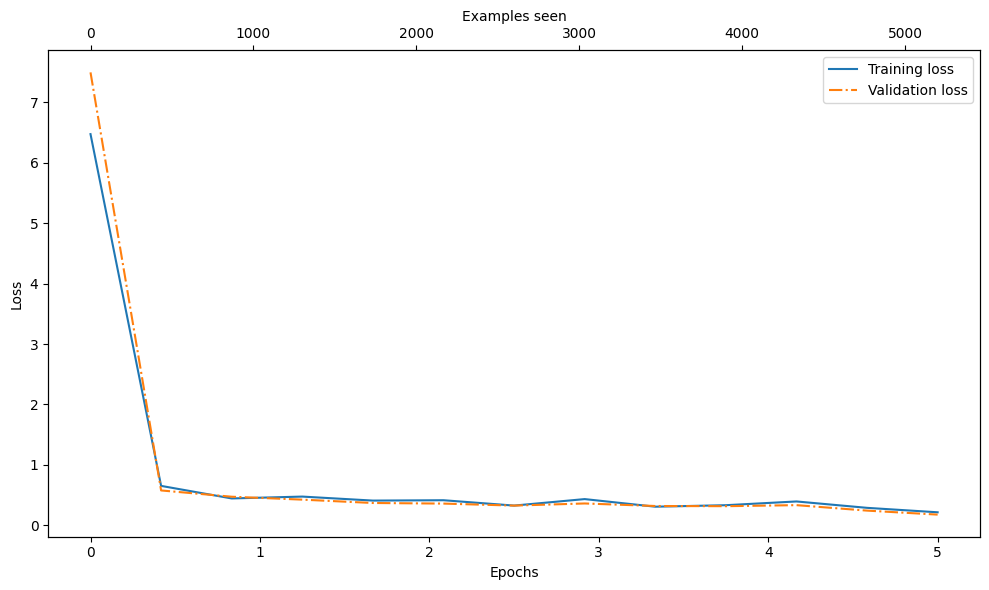

In [42]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

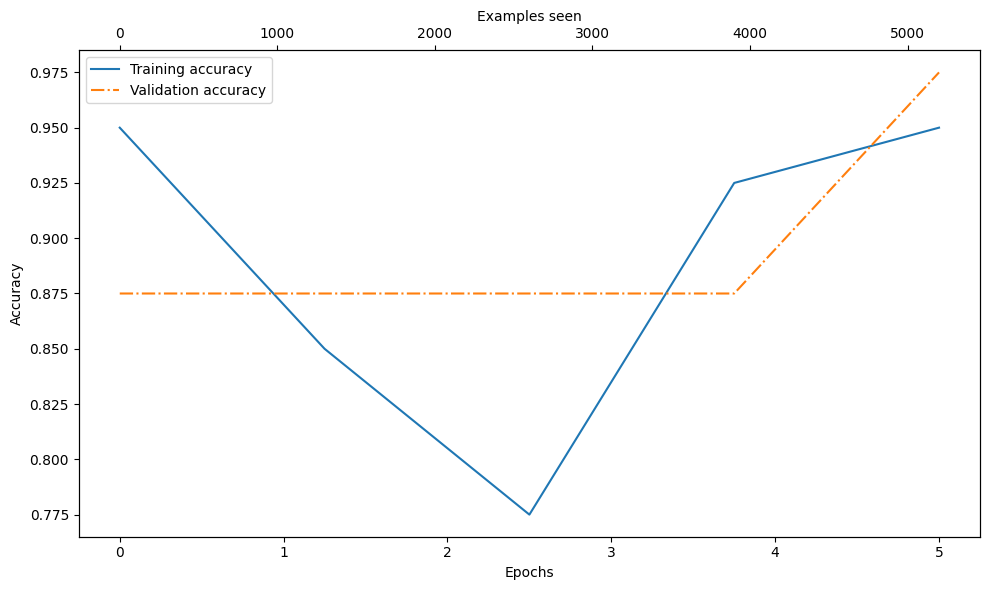

In [43]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [44]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 95.38%
Validation accuracy: 97.32%
Test accuracy: 96.33%


## 6.8 Using the LLM as a Spam Classifier

We can use the `classify_review` function below to classify new text messages as "spam" or "ham" using the fine-tuned model.

In [45]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]
    # Truncate sequences if they are too long
    input_ids = input_ids[:min(max_length, supported_context_length)]
    assert max_length is not None, (
        "max_length must be specified. If you want to use the full model context, "
        "pass max_length=model.pos_emb.weight.shape[0]."
    )
    assert max_length <= supported_context_length, (
        f"max_length ({max_length}) exceeds model's supported context length ({supported_context_length})."
    )

    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    # Model inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Return the classified result
    return "spam" if predicted_label == 1 else "not spam"

In [46]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(text_1, model, tokenizer, device, max_length=train_dataset.max_length))

spam


In [47]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(text_2, model, tokenizer, device, max_length=train_dataset.max_length))

not spam


In [ ]:
# Save the fine-tuned model
torch.save(model.state_dict(), "review_classifier.pth")

In [ ]:
# Load the fine-tuned model
model_state_dict = torch.load("review_classifier.pth", map_location=device, weights_only=True)
model.load_state_dict(model_state_dict)